In [9]:
import numpy as np
import gseapy
from scipy.sparse import csr_matrix
from tqdm.contrib.concurrent import process_map
from functools import partial
from scipy.sparse.csgraph import shortest_path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import SpectralEmbedding
from scipy.spatial import distance_matrix
import pandas as pd


from geneclusters.cluster_genes_new import get_scores, get_kernighan_lin_clusters, get_gene_pathway_matrix, get_full_matrix_from_bipartite

In [ ]:
names = gseapy.get_library_name()
print(names)

x = gseapy.get_library('GO_Biological_Process_2023')
np.save('./examples/GO_Biological_Process_2023.npy', x)

In [266]:
# try different K's

path = './examples/HumanCyc_2016.npy'

thresh = np.arange(5,150,5)
seed = np.repeat(5, len(thresh))
C = 0
KL_modified = True
random_labels = True
unweighted = True

results = process_map(partial(get_scores,path,C,KL_modified,random_labels,unweighted), seed, thresh)


  0%|          | 0/29 [00:00<?, ?it/s]

3it [00:01,  1.79it/s, tot_impr=1117, last_impr=0, loss=764] 2]
2it [00:02,  1.01s/it, tot_impr=520, last_impr=0, loss=1377]   
4it [00:02,  1.73it/s, tot_impr=1289, last_impr=0, loss=586]77]
4it [00:02,  1.70it/s, tot_impr=1467, last_impr=0, loss=380] ] 
4it [00:02,  1.66it/s, tot_impr=907, last_impr=0, loss=979]277]
4it [00:02,  1.50it/s, tot_impr=1420, last_impr=0, loss=454]
4it [00:02,  1.41it/s, tot_impr=1515, last_impr=0, loss=328]   
3it [00:03,  1.15s/it, tot_impr=1543, last_impr=0, loss=243]   
4it [00:03,  1.04it/s, tot_impr=1554, last_impr=0, loss=275]]  
5it [00:04,  1.22it/s, tot_impr=1523, last_impr=0, loss=313]   
4it [00:04,  1.03s/it, tot_impr=1534, last_impr=0, loss=269]]  
4it [00:04,  1.12s/it, tot_impr=1565, last_impr=0, loss=237] 
4it [00:04,  1.22s/it, tot_impr=1608, last_impr=0, loss=178]   
5it [00:04,  1.01it/s, tot_impr=1533, last_impr=0, loss=298]
4it [00:05,  1.28s/it, tot_impr=1557, last_impr=0, loss=236] 
4it [00:05,  1.40s/it, tot_impr=1605, last_impr=0,

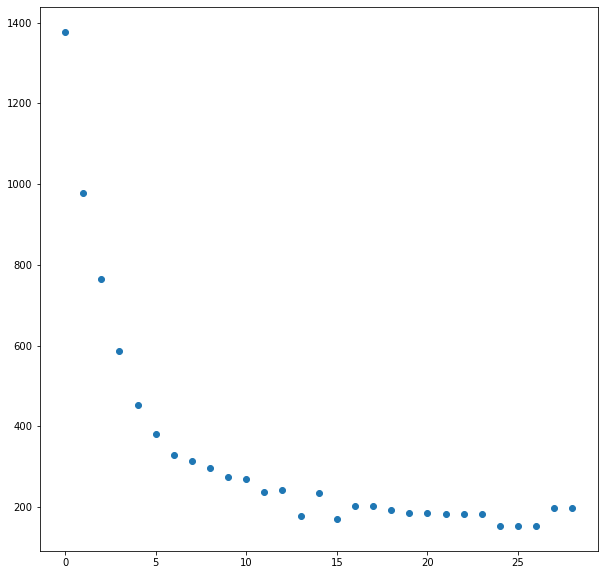

In [267]:
plt.figure(figsize=(10,10))


plt.scatter(range(len(results)), [results[x][1] for x in range(len(results))])

# average across multiple repeats

In [250]:
# normalize by all possible connections between clusters

10.465753424657533

In [268]:
path = './examples/HumanCyc_2016.npy'
repeats = 5

thresh = np.repeat(15,repeats)
seed = np.arange(repeats)
C = 0
KL_modified = True
random_labels = True
unweighted = True

results = process_map(partial(get_scores,path,C,KL_modified,random_labels,unweighted), seed, thresh)


  0%|          | 0/5 [00:00<?, ?it/s]

3it [00:01,  2.04it/s, tot_impr=1099, last_impr=0, loss=778]   
3it [00:01,  2.04it/s, tot_impr=1113, last_impr=0, loss=768] 
3it [00:01,  1.96it/s, tot_impr=1117, last_impr=0, loss=757] 
3it [00:01,  1.95it/s, tot_impr=1111, last_impr=0, loss=763] 
3it [00:01,  1.94it/s, tot_impr=1107, last_impr=0, loss=764] 


In [269]:
loss = np.hstack([x[1] for x in results])
labs = np.vstack([x[0] for x in results])
labels = labs[np.argmin(loss)]

In [270]:
# assign the clusters
frame, loss_temp = get_kernighan_lin_clusters(path, 15, C, KL_modified, random_labels, unweighted, seed=seed[np.argmin(loss)])
frame.columns = ['cluster', 'description', 'is_gene']

3it [00:01,  2.09it/s, tot_impr=1117, last_impr=0, loss=757]   


In [271]:
def sum_edges_between_clusters(path, frame, cluster_mapping):
    mat = get_gene_pathway_matrix(path)
    #mat = (pd.read_csv('../../github/ABCA7lof/processed_data/pathway_databases/gene_pathway_matrix.csv'))
    row_clusters = np.array([cluster_mapping[x] for x in mat.index])
    column_clusters = np.array([cluster_mapping[x] for x in mat.columns])
    clusters = np.unique(list(cluster_mapping.values()))
    n_clusters = len(clusters)
    out = np.zeros((n_clusters, n_clusters))
    mat_array = np.array(mat)
    
    row_cluster_indices = [np.where(row_clusters==x)[0] for x in clusters]
    col_cluster_indices = [np.where(column_clusters==x)[0] for x in clusters]
    
    compute_sums(n_clusters, mat_array, row_cluster_indices, col_cluster_indices, out)
    return out, n_clusters, clusters

def compute_sums(n_clusters, mat_array, row_cluster_indices, col_cluster_indices, out):
    for i in range(n_clusters):
        for j in range(n_clusters):
            out[i,j] = np.sum(mat_array[row_cluster_indices[i]][:,col_cluster_indices[j]])+np.sum(mat_array[row_cluster_indices[j]][:,col_cluster_indices[i]])
            
def compute_embedding_distances(out, n_clusters):
    embedding = SpectralEmbedding(1)
    embedded = embedding.fit_transform(out)
    #distances = np.zeros((n_clusters, n_clusters))
    #for i in range(n_clusters):
    #    for j in range(n_clusters):
    #        distances[i,j] = np.abs(embedded[i]-embedded[j])
    distances = distance_matrix(out, out)
    return distances, embedded.ravel()

In [272]:
cluster_mapping = dict(zip(frame['description'], frame['cluster']))
out, n_clusters, clusters = sum_edges_between_clusters(path, frame, cluster_mapping)
pairwise_distances, embedded = compute_embedding_distances(out, n_clusters)

In [273]:
pairwise_distances.shape

(73, 73)

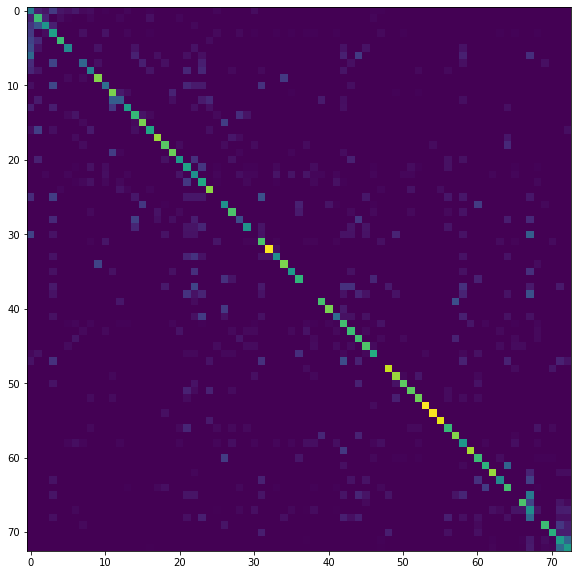

In [274]:
plt.figure(figsize=(10,10))

sorted_mat = out[np.argsort(embedded)][:,np.argsort(embedded)]

#plt.imshow()
original = plt.imshow(sorted_mat/np.sum(sorted_mat, axis=1).reshape(-1,1))
#plt.imshow(sorted_mat)
original

(array([ 97., 194., 312., 460., 820., 690., 266., 520., 442., 342., 344.,
        230., 156., 110., 104., 160.,  44.,  26.,   6.,   6.]),
 array([  0.        ,   7.21370224,  14.42740448,  21.64110672,
         28.85480896,  36.0685112 ,  43.28221344,  50.49591568,
         57.70961792,  64.92332016,  72.13702239,  79.35072463,
         86.56442687,  93.77812911, 100.99183135, 108.20553359,
        115.41923583, 122.63293807, 129.84664031, 137.06034255,
        144.27404479]),
 <BarContainer object of 20 artists>)

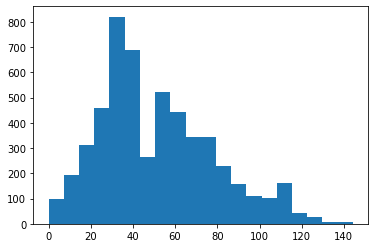

In [275]:
plt.hist(pairwise_distances.ravel(), 20)

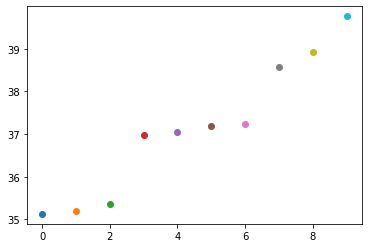

In [287]:
np.fill_diagonal(pairwise_distances, np.inf)
x=0
while np.min(pairwise_distances)<40:
    y = np.min(pairwise_distances)
    plt.scatter(x, y)
    x+=1
    min_index = np.argmin(pairwise_distances)
    cluster_0 = min_index//pairwise_distances.shape[1]
    cluster_1 = min_index%pairwise_distances.shape[1]

    frame.loc[frame['cluster']==cluster_0,'cluster']=cluster_1

    remap = dict(zip(np.unique(frame['cluster']), range(len(np.unique(frame['cluster'])))))
    frame['cluster'] = [remap[x] for x in frame['cluster']]

    cluster_mapping = dict(zip(frame['description'], frame['cluster']))
    out, n_clusters, clusters = sum_edges_between_clusters(path, frame, cluster_mapping)
    pairwise_distances, embedded = compute_embedding_distances(out, n_clusters)
    np.fill_diagonal(pairwise_distances, np.inf)


In [288]:
out.shape

(43, 43)

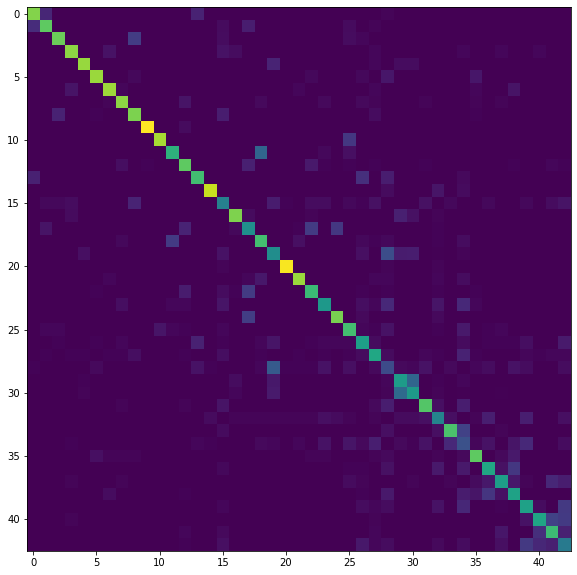

In [289]:
plt.figure(figsize=(10,10))

sorted_mat = out[np.argsort(embedded)][:,np.argsort(embedded)]

#plt.imshow()
new = plt.imshow(sorted_mat/np.sum(sorted_mat, axis=1).reshape(-1,1))

In [230]:
original
plt.show()

In [290]:
np.min(np.diag(out)-(np.sum(np.tril(out, k=-1), axis=1)))

-22.0

In [152]:
np.diag(out)/np.sum(np.tril(out, k=0), axis=1)

array([1.        , 1.        , 1.        , 1.        , 0.94545455,
       0.88888889, 0.93333333, 0.97435897, 0.99328859, 1.        ,
       0.944     , 0.87804878, 0.79365079, 0.81481481, 0.87323944,
       0.66666667, 0.8       , 0.93023256, 0.93333333, 0.8372093 ,
       0.92682927, 0.6779661 , 0.73170732, 0.703125  , 0.96      ,
       0.92537313, 0.74074074, 0.93023256, 0.62222222, 0.97142857,
       0.95890411, 0.82352941, 0.        , 0.91891892, 0.71794872,
       0.5988024 , 0.64383562])

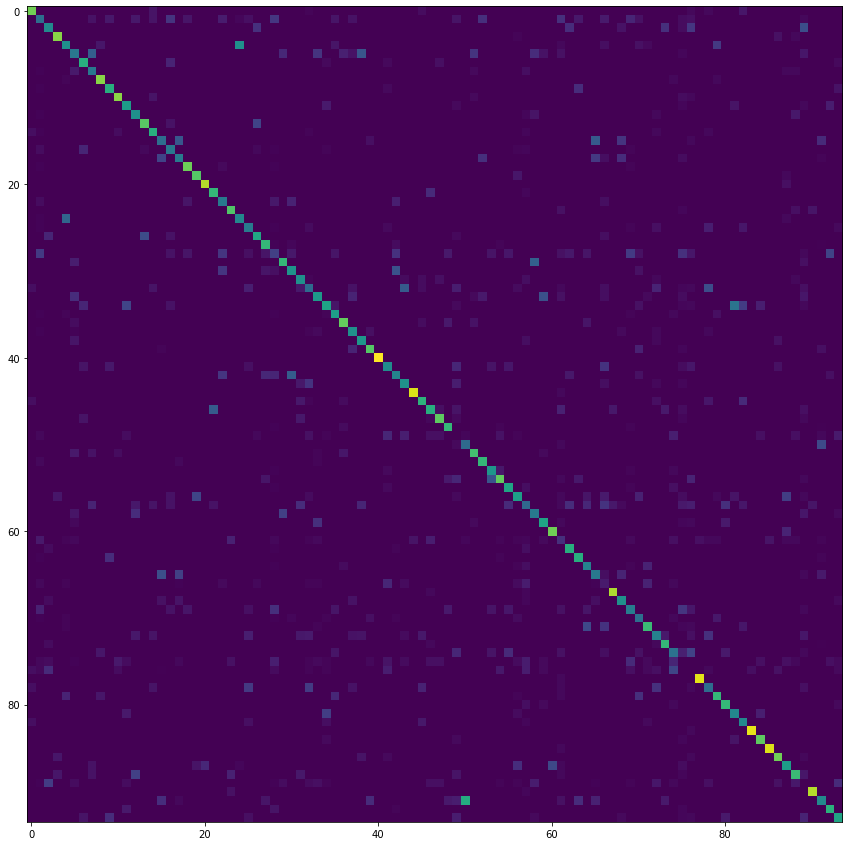

In [554]:
plt.figure(figsize=(15,15))

#plt.imshow(out[np.argsort(embedded)][:,np.argsort(embedded)])
plt.imshow(out/np.sum(out, axis=1))

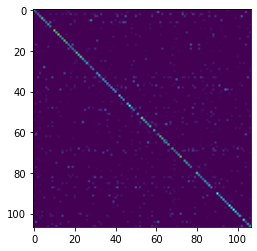

In [546]:
plt.imshow(out/np.sum(out, axis=1))

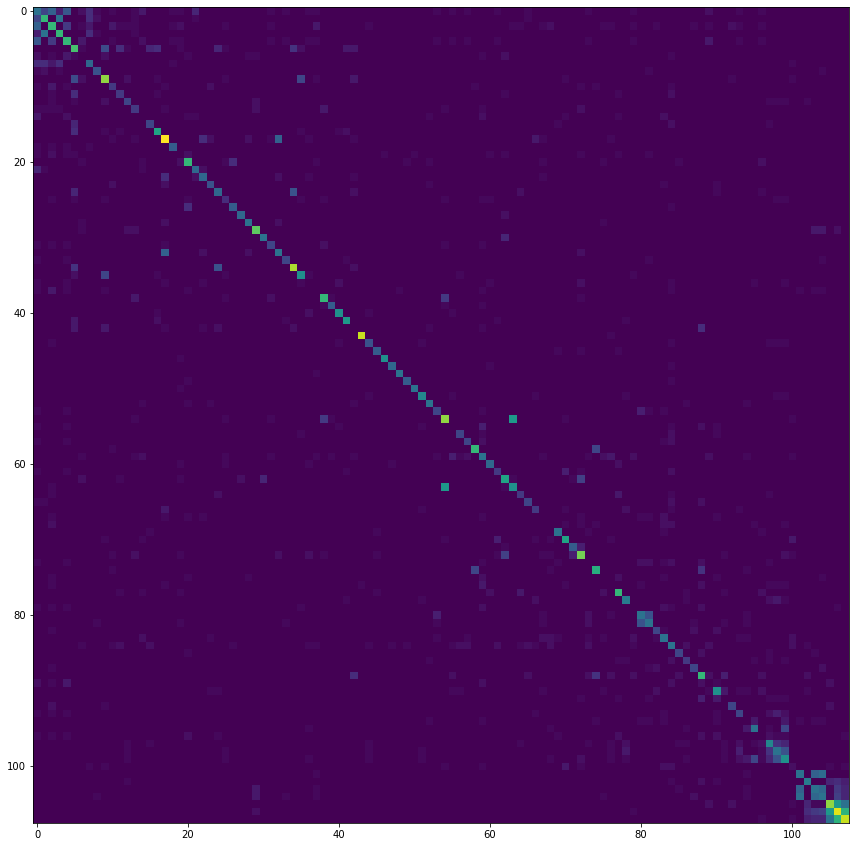

In [472]:
plt.figure(figsize=(15,15))

plt.imshow(out[np.argsort(embedded)][:,np.argsort(embedded)])

In [443]:
row_clusters[row_clusters==row_index]=col_index

In [444]:
row_clusters

array([40, 33, 21,  7, 14,  5, 31, 31, 31, 31, 13, 19, 19, 23, 23, 23, 54,
       54, 54, 54, 54, 48,  6,  6, 14, 26, 26, 42, 42, 42, 22, 29, 20, 55,
       44, 44,  6,  6, 12, 35, 35, 35, 35, 35, 35,  2,  5,  5, 39, 39, 34,
       34, 34, 34, 34, 34, 41,  9,  9,  9,  9, 18, 38, 38, 38, 38, 38, 38,
        8, 25, 22, 22, 46, 46, 46, 46, 46, 46, 16, 18, 18, 18, 18, 18, 40,
       40, 40,  1,  1, 43,  1, 32, 32, 32, 30, 30, 30, 30, 30, 30, 30, 37,
       37, 30, 30, 30, 37, 37, 17, 16,  4,  4, 52, 45, 45, 45, 48,  3,  0,
       17, 43, 52, 13, 53, 15, 41, 41, 14, 27, 44, 47,  2, 36, 36, 10, 10,
       10, 10, 12, 51, 51, 33, 53, 53, 50, 28, 20, 11, 50, 50, 15, 29])

In [437]:
row_cluster_indices[col_index]

IndexError: list index out of range

In [434]:
cluster_mapping

{'A4GNT': 3,
 'AADAT': 72,
 'AANAT': 46,
 'AARS': 17,
 'AARS2': 43,
 'ABAT': 4,
 'ABHD12': 47,
 'ABHD5': 58,
 'ABHD6': 62,
 'ACAA1': 97,
 'ACAA2': 96,
 'ACAD8': 29,
 'ACADL': 96,
 'ACADSB': 69,
 'ACAT1': 85,
 'ACAT2': 94,
 'ACER1': 55,
 'ACER2': 75,
 'ACMSD': 72,
 'ACO2': 53,
 'ACOT2': 20,
 'ACOT4': 7,
 'ACOT7': 7,
 'ACOT8': 7,
 'ACOX1': 43,
 'ACOX2': 99,
 'ACSBG1': 41,
 'ACSBG2': 41,
 'ACSL1': 41,
 'ACSL3': 41,
 'ACSL4': 41,
 'ACSL5': 96,
 'ACSL6': 96,
 'ACSM1': 47,
 'ACSM3': 14,
 'ACSM4': 14,
 'ACSM5': 14,
 'ACSM6': 90,
 'ACSS1': 64,
 'ACSS2': 64,
 'ACSS3': 64,
 'ADA': 48,
 'ADH1B': 6,
 'ADH4': 8,
 'ADH6': 6,
 'ADI1': 74,
 'ADK': 88,
 'ADSL': 75,
 'ADSS': 63,
 'ADSSL1': 106,
 'AFMID': 36,
 'AGL': 104,
 'AGPAT1': 91,
 'AGPAT2': 67,
 'AGPAT3': 58,
 'AGPAT4': 67,
 'AGPAT5': 58,
 'AGPAT6': 54,
 'AGPAT9': 67,
 'AHCY': 81,
 'AK1': 63,
 'AK2': 1,
 'AK3': 62,
 'AK4': 1,
 'AK5': 106,
 'AK7': 1,
 'AK8': 63,
 'AKR1A1': 69,
 'AKR1B1': 75,
 'AKR1B10': 65,
 'AKR1C1': 78,
 'AKR1C2': 78,
 'AKR1C3': 

In [429]:
list(cluster_mapping.values())

[3,
 72,
 46,
 17,
 43,
 4,
 47,
 58,
 62,
 97,
 96,
 29,
 96,
 69,
 85,
 94,
 55,
 75,
 72,
 53,
 20,
 7,
 7,
 7,
 43,
 99,
 41,
 41,
 41,
 41,
 41,
 96,
 96,
 47,
 14,
 14,
 14,
 90,
 64,
 64,
 64,
 48,
 6,
 8,
 6,
 74,
 88,
 75,
 63,
 106,
 36,
 104,
 91,
 67,
 58,
 67,
 58,
 54,
 67,
 81,
 63,
 1,
 62,
 1,
 106,
 1,
 63,
 69,
 75,
 65,
 78,
 78,
 86,
 78,
 99,
 98,
 98,
 98,
 26,
 26,
 26,
 44,
 69,
 17,
 64,
 44,
 6,
 44,
 44,
 4,
 54,
 15,
 31,
 31,
 93,
 100,
 100,
 100,
 69,
 100,
 100,
 28,
 42,
 99,
 74,
 38,
 32,
 64,
 73,
 74,
 1,
 107,
 69,
 55,
 55,
 55,
 107,
 46,
 107,
 17,
 106,
 1,
 63,
 63,
 63,
 1,
 106,
 63,
 106,
 106,
 106,
 106,
 63,
 63,
 1,
 80,
 33,
 33,
 33,
 33,
 101,
 50,
 101,
 91,
 101,
 33,
 99,
 70,
 70,
 70,
 102,
 85,
 85,
 60,
 93,
 24,
 29,
 65,
 89,
 62,
 64,
 25,
 60,
 72,
 83,
 95,
 84,
 101,
 69,
 67,
 43,
 38,
 77,
 10,
 54,
 26,
 81,
 75,
 15,
 77,
 12,
 77,
 16,
 16,
 16,
 80,
 16,
 16,
 16,
 16,
 76,
 76,
 76,
 76,
 76,
 21,
 21,
 105,
 34,

In [410]:
list(cluster_mapping.values())

[3,
 72,
 46,
 17,
 43,
 4,
 47,
 58,
 62,
 97,
 96,
 29,
 96,
 69,
 85,
 94,
 55,
 75,
 72,
 53,
 20,
 7,
 7,
 7,
 43,
 99,
 41,
 41,
 41,
 41,
 41,
 96,
 96,
 47,
 14,
 14,
 14,
 90,
 64,
 64,
 64,
 48,
 6,
 8,
 6,
 74,
 88,
 75,
 63,
 106,
 36,
 104,
 91,
 67,
 58,
 67,
 58,
 54,
 67,
 81,
 63,
 1,
 62,
 1,
 106,
 1,
 63,
 69,
 75,
 65,
 78,
 78,
 86,
 78,
 99,
 98,
 98,
 98,
 26,
 26,
 26,
 44,
 69,
 17,
 64,
 44,
 6,
 44,
 44,
 4,
 54,
 15,
 31,
 31,
 93,
 100,
 100,
 100,
 69,
 100,
 100,
 28,
 42,
 99,
 74,
 38,
 32,
 64,
 73,
 74,
 1,
 107,
 69,
 55,
 55,
 55,
 107,
 46,
 107,
 17,
 106,
 1,
 63,
 63,
 63,
 1,
 106,
 63,
 106,
 106,
 106,
 106,
 63,
 63,
 1,
 80,
 33,
 33,
 33,
 33,
 101,
 50,
 101,
 91,
 101,
 33,
 99,
 70,
 70,
 70,
 102,
 85,
 85,
 60,
 93,
 24,
 29,
 65,
 89,
 62,
 64,
 25,
 60,
 72,
 83,
 95,
 84,
 101,
 69,
 67,
 43,
 38,
 77,
 10,
 54,
 26,
 81,
 75,
 15,
 77,
 12,
 77,
 16,
 16,
 16,
 80,
 16,
 16,
 16,
 16,
 76,
 76,
 76,
 76,
 76,
 21,
 21,
 105,
 34,

In [407]:
col_index

82

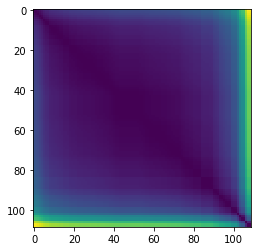

In [362]:
plt.imshow(pairwise_distances[np.argsort(embedded)][:,np.argsort(embedded)])

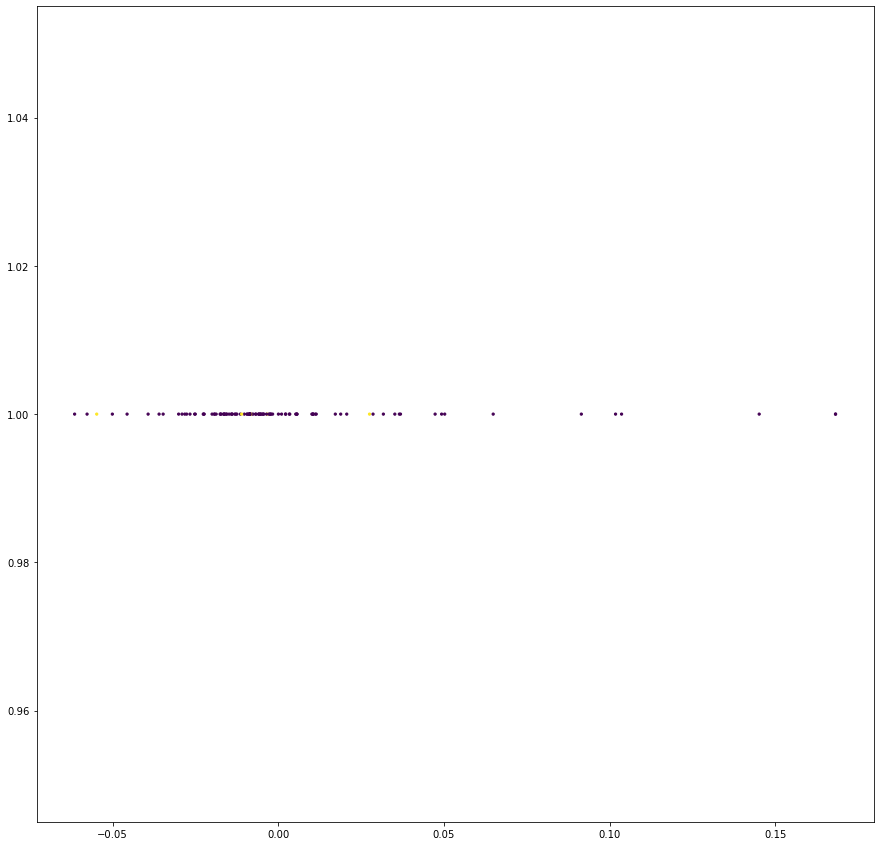

In [398]:
plt.figure(figsize=(15,15))

embedding2 = SpectralEmbedding(1)
embedding2 = embedding2.fit_transform(out)
plt.scatter(embedding2.ravel(), y = np.repeat(1, len(embedding2.ravel())), s = 5, c =(np.argsort(embedded)<5))

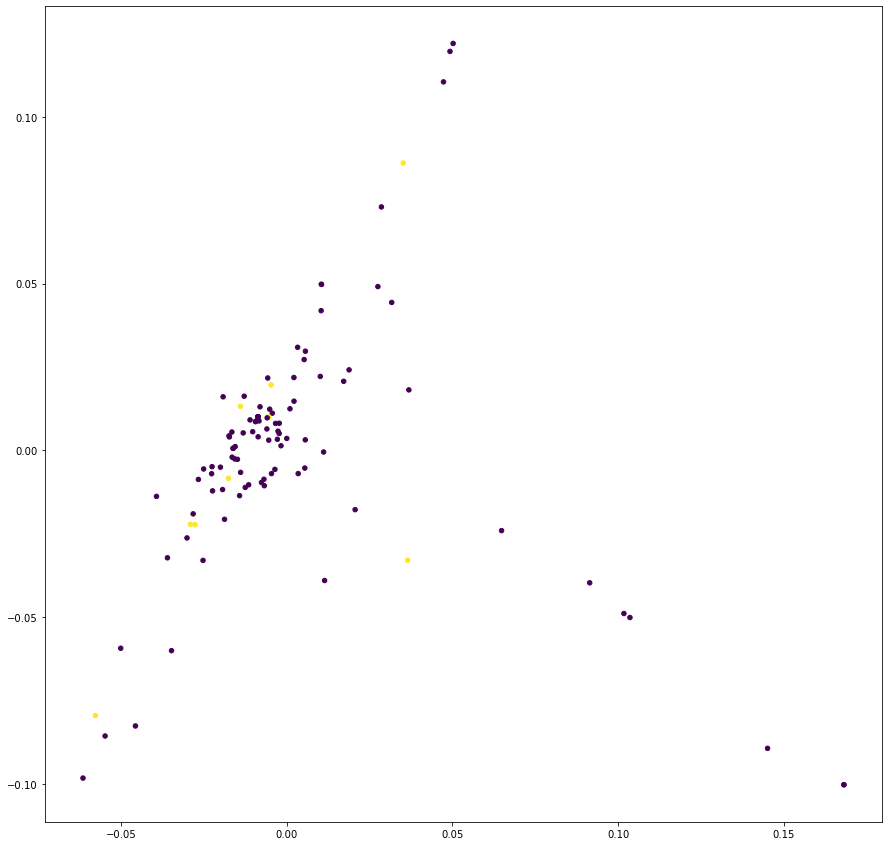

In [383]:
plt.figure(figsize=(15,15))

embedding2 = SpectralEmbedding(1)
embedding2 = embedding2.fit_transform(out)
plt.scatter(embedding2[:,0], embedding2[:,1], s = 20, c =(np.argsort(embedded)>40) & (np.argsort(embedded)<50))

In [ ]:
# iteratively merge the two closest clusters; then re-compute distances then merge again until some threshold
# what about non-connected components for the spectral clustering?
# show for different K's 
# plot K by average loss per cluster
# merge similar clusters
# then plot with spring layout (run on unconnected clusters separately)
# only show the leading edge genes as nodes to keep cleaner?

In [222]:
np.fill_diagonal(pairwise_distances, np.inf)

In [223]:
min_index = np.argmin(pairwise_distances)

In [224]:
row_index = min_index//pairwise_distances.shape[1]
col_index = min_index%pairwise_distances.shape[1]

In [225]:
pairwise_distances[row_index,col_index]

0.0

In [234]:
row_index

1

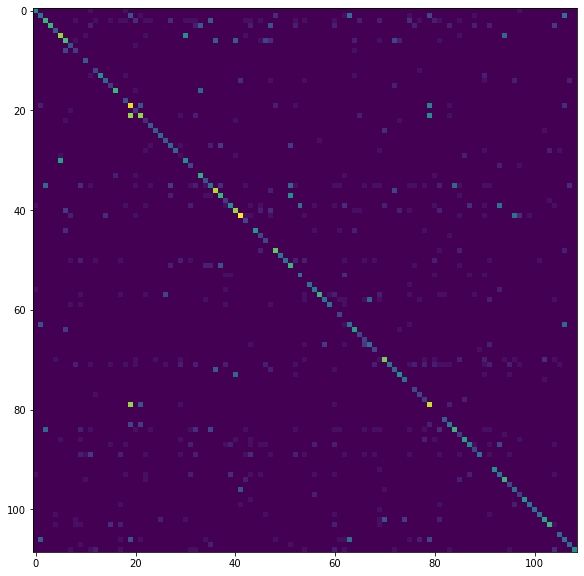

In [262]:
plt.figure(figsize=(10,10))

plt.imshow(out)

In [252]:
embedded.ravel()[5]

-0.02760093749015082

In [249]:
embedded.ravel()[9]

-0.017846668149981433

In [242]:
out[1]

array([ 0., 21.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])

In [243]:
out[:,9]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 29.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])

In [236]:
pairwise_distances[1]

array([1.03216603e-01,            inf, 1.04083409e-17, 4.48995754e-02,
       1.80971451e-02, 9.75426934e-03, 1.80971451e-02, 5.53736193e-03,
       2.10024475e-02, 0.00000000e+00, 6.93889390e-17, 5.76777771e-02,
       5.55063280e-02, 7.40167453e-02, 5.89805982e-17, 4.85722573e-17,
       2.08166817e-17, 7.97972799e-17, 3.81639165e-17, 1.32047598e-01,
       1.04083409e-17, 3.14172141e-03, 9.71489930e-03, 1.22337828e-01,
       2.26420025e-02, 1.82172376e-02, 2.91857801e-02, 1.29315858e-01,
       9.75426934e-03, 3.81639165e-17, 3.51829686e-01, 5.18927839e-02,
       2.92233588e-01, 6.93889390e-17, 4.85722573e-17, 1.42622083e-01,
       9.75426934e-03, 1.49487715e-01, 1.29315858e-01, 6.19200106e-02,
       5.89805982e-17, 5.53736193e-03, 7.20016967e-04, 0.00000000e+00,
       3.81639165e-17, 2.08166817e-17, 1.25587417e-02, 2.18568834e-01,
       1.21346476e-02, 1.32810052e-02, 6.93889390e-17, 3.81639165e-17,
       1.21346476e-02, 9.02056208e-17, 1.17961196e-16])

In [237]:
pairwise_distances[:,9]

array([1.03216603e-01, 0.00000000e+00, 1.04083409e-17, 4.48995754e-02,
       1.80971451e-02, 9.75426934e-03, 1.80971451e-02, 5.53736193e-03,
       2.10024475e-02,            inf, 6.93889390e-17, 5.76777771e-02,
       5.55063280e-02, 7.40167453e-02, 5.89805982e-17, 4.85722573e-17,
       2.08166817e-17, 7.97972799e-17, 3.81639165e-17, 1.32047598e-01,
       1.04083409e-17, 3.14172141e-03, 9.71489930e-03, 1.22337828e-01,
       2.26420025e-02, 1.82172376e-02, 2.91857801e-02, 1.29315858e-01,
       9.75426934e-03, 3.81639165e-17, 3.51829686e-01, 5.18927839e-02,
       2.92233588e-01, 6.93889390e-17, 4.85722573e-17, 1.42622083e-01,
       9.75426934e-03, 1.49487715e-01, 1.29315858e-01, 6.19200106e-02,
       5.89805982e-17, 5.53736193e-03, 7.20016967e-04, 0.00000000e+00,
       3.81639165e-17, 2.08166817e-17, 1.25587417e-02, 2.18568834e-01,
       1.21346476e-02, 1.32810052e-02, 6.93889390e-17, 3.81639165e-17,
       1.21346476e-02, 9.02056208e-17, 1.17961196e-16])

In [233]:
distances

array([[0.00000000e+00, 1.03216603e-01, 1.03216603e-01, ...,
        1.15351251e-01, 1.03216603e-01, 1.03216603e-01],
       [1.03216603e-01, 0.00000000e+00, 2.08166817e-17, ...,
        1.21346476e-02, 1.42247325e-16, 1.04083409e-16],
       [1.03216603e-01, 2.08166817e-17, 0.00000000e+00, ...,
        1.21346476e-02, 1.21430643e-16, 8.32667268e-17],
       ...,
       [1.15351251e-01, 1.21346476e-02, 1.21346476e-02, ...,
        0.00000000e+00, 1.21346476e-02, 1.21346476e-02],
       [1.03216603e-01, 1.42247325e-16, 1.21430643e-16, ...,
        1.21346476e-02, 0.00000000e+00, 3.81639165e-17],
       [1.03216603e-01, 1.04083409e-16, 8.32667268e-17, ...,
        1.21346476e-02, 3.81639165e-17, 0.00000000e+00]])

In [218]:
pairwise_distances

array([[           inf, 1.03216603e-01, 1.03216603e-01, ...,
        1.15351251e-01, 1.03216603e-01, 1.03216603e-01],
       [1.03216603e-01,            inf, 2.42861287e-17, ...,
        1.21346476e-02, 1.04083409e-17, 4.16333634e-17],
       [1.03216603e-01, 2.42861287e-17,            inf, ...,
        1.21346476e-02, 1.38777878e-17, 1.73472348e-17],
       ...,
       [1.15351251e-01, 1.21346476e-02, 1.21346476e-02, ...,
                   inf, 1.21346476e-02, 1.21346476e-02],
       [1.03216603e-01, 1.04083409e-17, 1.38777878e-17, ...,
        1.21346476e-02,            inf, 3.12250226e-17],
       [1.03216603e-01, 4.16333634e-17, 1.73472348e-17, ...,
        1.21346476e-02, 3.12250226e-17,            inf]])

In [184]:
pairwise_distances[10,1]

1.0408340855860843e-17

In [183]:
pairwise_distances[1,10]

1.0408340855860843e-17

In [88]:
mat = get_gene_pathway_matrix(path)


cluster_mapping = dict(zip(frame['description'], frame['cluster']))
row_clusters = np.array([cluster_mapping[x] for x in mat.index])
column_clusters = np.array([cluster_mapping[x] for x in mat.columns])
clusters = np.unique(frame['cluster'])
n_clusters = len(clusters)
out = np.zeros((n_clusters, n_clusters))
mat_array = np.array(mat)

In [89]:
row_cluster_indices = [np.where(row_clusters==x)[0] for x in clusters]
col_cluster_indices = [np.where(column_clusters==x)[0] for x in clusters]

In [91]:
embedding = SpectralEmbedding(1)
order = np.argsort(embedding.fit_transform(out)[:, 0])
ordered = out[order][:, order]

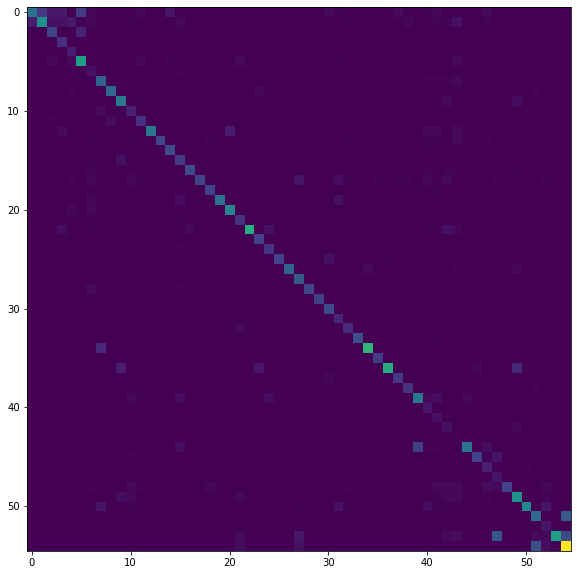

In [92]:
plt.figure(figsize=(10,10))

plt.imshow(ordered)


In [119]:
embedding = SpectralEmbedding(1)

embedded = embedding.fit_transform(out).ravel()

In [ ]:
# iteratively merge the two closest clusters; then re-compute distances then merge again until some threshold

In [113]:
distances = np.zeros((n_clusters, n_clusters))
for i in range(n_clusters):
    for j in range(n_clusters):
        distances[i,j] = np.abs(embedded[i]-embedded[j])

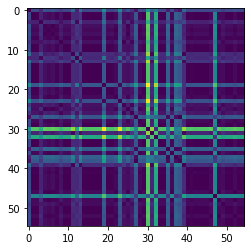

In [115]:
plt.imshow(distances)

In [145]:
clusters_to_merge = np.ones(n_clusters)*-1
temp = np.ma.masked_array(distances, mask=distances==0)
for i in range(n_clusters):
    if np.min(temp[i])<0.01:
        clusters_to_merge[i] = np.argmin(temp[i])

In [148]:
ordered

array([[34., 15.,  6., ...,  0.,  0.,  0.],
       [ 7., 44.,  4., ...,  0.,  0.,  0.],
       [ 0.,  0., 18., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  5.,  0.,  0.],
       [ 0.,  0.,  0., ...,  2., 51., 20.],
       [ 0.,  0.,  0., ...,  3.,  1., 90.]])

In [149]:
clusters_to_merge

array([-1.,  2., 50., -1.,  6., 36.,  4., 41., 24., 20., 16., 39., -1.,
       -1., 16., 16., 10., 20., 10., 23.,  9., 42., 36., 19.,  8.,  6.,
       24., 38.,  5., 16., -1., 11., -1., 50., 10., 37.,  5., 35., 27.,
       11., 43.,  7.,  1., 40., 10.,  9., 48., -1., 52.,  8.,  2.,  2.,
       48., 40.,  9.])

In [141]:
temp

masked_array(
  data=[[--, 0.1032166031325721, 0.10321660313257212, ...,
         0.11535125077406898, 0.10321660313257225, 0.10321660313257221],
        [0.1032166031325721, --, 2.0816681711721685e-17, ...,
         0.012134647641496882, 1.4224732503009818e-16,
         1.0408340855860843e-16],
        [0.10321660313257212, 2.0816681711721685e-17, --, ...,
         0.012134647641496861, 1.214306433183765e-16,
         8.326672684688674e-17],
        ...,
        [0.11535125077406898, 0.012134647641496882, 0.012134647641496861,
         ..., --, 0.01213464764149674, 0.012134647641496778],
        [0.10321660313257225, 1.4224732503009818e-16,
         1.214306433183765e-16, ..., 0.01213464764149674, --,
         3.8163916471489756e-17],
        [0.10321660313257221, 1.0408340855860843e-16,
         8.326672684688674e-17, ..., 0.012134647641496778,
         3.8163916471489756e-17, --]],
  mask=[[ True, False, False, ..., False, False, False],
        [False,  True, False, ..., False, Fal

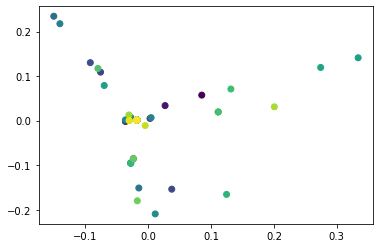

In [125]:
embedding = SpectralEmbedding(2)

x = embedding.fit_transform(out)
plt.scatter(x[:,0], x[:,1], c = range(len(distances)))

In [124]:
distances

array([[0.00000000e+00, 1.03216603e-01, 1.03216603e-01, ...,
        1.15351251e-01, 1.03216603e-01, 1.03216603e-01],
       [1.03216603e-01, 0.00000000e+00, 2.08166817e-17, ...,
        1.21346476e-02, 1.42247325e-16, 1.04083409e-16],
       [1.03216603e-01, 2.08166817e-17, 0.00000000e+00, ...,
        1.21346476e-02, 1.21430643e-16, 8.32667268e-17],
       ...,
       [1.15351251e-01, 1.21346476e-02, 1.21346476e-02, ...,
        0.00000000e+00, 1.21346476e-02, 1.21346476e-02],
       [1.03216603e-01, 1.42247325e-16, 1.21430643e-16, ...,
        1.21346476e-02, 0.00000000e+00, 3.81639165e-17],
       [1.03216603e-01, 1.04083409e-16, 8.32667268e-17, ...,
        1.21346476e-02, 3.81639165e-17, 0.00000000e+00]])

In [96]:
ordered.shape

(55, 55)

In [58]:
# iteratively merge the two closest clusters; then re-compute distances then merge again until some threshold
# what about non-connected components for the spectral clustering?
# show for different K's 
# plot K by average loss per cluster
# merge similar clusters
# then plot with spring layout (run on unconnected clusters separately)
# only show the leading edge genes as nodes to keep cleaner?

array([[44.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., 63.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 58., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 31.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., 25.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1., 24.]])

In [9]:
n_clusters = len(clusters)
out = np.zeros((n_clusters, n_clusters))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36])

##### more scrap

In [7]:
import numpy as np
import gseapy
from scipy.sparse import csr_matrix
from tqdm.contrib.concurrent import process_map
from functools import partial
from scipy.sparse.csgraph import shortest_path
import matplotlib.pyplot as plt
from geneclusters.cluster_genes_new import evaluate_cut,assign_cluster_based_on_proba,create_random_labeling, distance_to_probability,get_gene_pathway_matrix, get_full_matrix_from_bipartite,run_KL, compute_cost_metrics, add_outer, get_kernighan_lin_clusters, create_nonrandom_labeling

In [9]:
#names = gseapy.get_library_name()
#x = gseapy.get_library('KEGG_2021_Human')
#np.save('./examples/KEGG_2021_Human.npy', x)

In [ ]:

# compare performance of the different variants of this method and also of the other methods of interest

# choose which method works best and compare against G's original clustering
# compare against some other clustering methods like actionet etc?

In [3]:
mat = get_gene_pathway_matrix('./examples/HumanCyc_2016.npy')
matrix = np.ascontiguousarray(mat.values.T)


In [4]:
def get_scores(path, C, KL_modified, random_labels, unweighted, seed, thresh):
    np.random.randint(1000)
    o1, o2 = get_kernighan_lin_clusters(path, thresh, C, KL_modified, random_labels, unweighted, seed)
    return np.array(o1[0]), o2

  0%|          | 0/19 [00:00<?, ?it/s]

3it [00:05,  1.83s/it, tot_impr=958, last_impr=0, loss=906]8]9]
3it [00:05,  1.84s/it, tot_impr=1101, last_impr=0, loss=782] 
3it [00:05,  1.91s/it, tot_impr=975, last_impr=0, loss=908] ]  
4it [00:05,  1.48s/it, tot_impr=1242, last_impr=0, loss=631] 
4it [00:05,  1.48s/it, tot_impr=1063, last_impr=0, loss=812] 
4it [00:06,  1.50s/it, tot_impr=1317, last_impr=0, loss=548] 
4it [00:06,  1.53s/it, tot_impr=1410, last_impr=0, loss=438]
4it [00:06,  1.57s/it, tot_impr=908, last_impr=0, loss=980]] 
4it [00:06,  1.56s/it, tot_impr=870, last_impr=0, loss=1007]
3it [00:06,  2.11s/it, tot_impr=747, last_impr=0, loss=1144] 
4it [00:06,  1.60s/it, tot_impr=1501, last_impr=0, loss=333]
3it [00:06,  2.13s/it, tot_impr=1527, last_impr=0, loss=278] 
5it [00:06,  1.29s/it, tot_impr=1112, last_impr=0, loss=755]
3it [00:06,  2.14s/it, tot_impr=695, last_impr=0, loss=1195] 
4it [00:06,  1.61s/it, tot_impr=814, last_impr=0, loss=1077]
4it [00:06,  1.62s/it, tot_impr=845, last_impr=0, loss=1044]
4it [00:06

  0%|          | 0/19 [00:00<?, ?it/s]

3it [00:05,  1.99s/it, tot_impr=1081, last_impr=0, loss=796]  ]
3it [00:06,  2.00s/it, tot_impr=884, last_impr=0, loss=997]
3it [00:06,  2.04s/it, tot_impr=884, last_impr=0, loss=997]] 
3it [00:06,  2.05s/it, tot_impr=818, last_impr=0, loss=1066] 
4it [00:06,  1.60s/it, tot_impr=1027, last_impr=0, loss=851]   
4it [00:06,  1.63s/it, tot_impr=949, last_impr=0, loss=933]] 
4it [00:06,  1.65s/it, tot_impr=1171, last_impr=0, loss=705]
4it [00:06,  1.66s/it, tot_impr=1462, last_impr=0, loss=396] 
5it [00:06,  1.37s/it, tot_impr=1245, last_impr=0, loss=626] 
4it [00:06,  1.73s/it, tot_impr=801, last_impr=0, loss=1086]
4it [00:06,  1.73s/it, tot_impr=801, last_impr=0, loss=1086]
4it [00:07,  1.75s/it, tot_impr=1481, last_impr=0, loss=357]
5it [00:07,  1.41s/it, tot_impr=1332, last_impr=0, loss=538]
3it [00:07,  2.34s/it, tot_impr=629, last_impr=0, loss=1260]
4it [00:07,  1.80s/it, tot_impr=726, last_impr=0, loss=1164] 
4it [00:07,  1.83s/it, tot_impr=726, last_impr=0, loss=1164]
4it [00:07,  

  0%|          | 0/19 [00:00<?, ?it/s]

3it [00:05,  1.77s/it, tot_impr=1068, last_impr=0, loss=811]   
3it [00:05,  1.84s/it, tot_impr=1447, last_impr=0, loss=416] 5]
4it [00:05,  1.45s/it, tot_impr=1310, last_impr=0, loss=548]]  
3it [00:05,  1.91s/it, tot_impr=966, last_impr=0, loss=921] 
4it [00:05,  1.46s/it, tot_impr=1116, last_impr=0, loss=763]
3it [00:05,  1.97s/it, tot_impr=737, last_impr=0, loss=1154] 
4it [00:05,  1.49s/it, tot_impr=1281, last_impr=0, loss=586] 
4it [00:06,  1.50s/it, tot_impr=1115, last_impr=0, loss=766]
4it [00:05,  1.47s/it, tot_impr=1054, last_impr=0, loss=830]
3it [00:06,  2.00s/it, tot_impr=777, last_impr=0, loss=1109] 
3it [00:05,  1.98s/it, tot_impr=721, last_impr=0, loss=1166] 
4it [00:06,  1.54s/it, tot_impr=937, last_impr=0, loss=948]
4it [00:06,  1.60s/it, tot_impr=833, last_impr=0, loss=1047] 
4it [00:06,  1.59s/it, tot_impr=898, last_impr=0, loss=988]]
4it [00:06,  1.63s/it, tot_impr=795, last_impr=0, loss=1090]
4it [00:06,  1.74s/it, tot_impr=693, last_impr=0, loss=1199]]  
5it [00:

  0%|          | 0/19 [00:00<?, ?it/s]

3it [00:05,  1.93s/it, tot_impr=1060, last_impr=0, loss=816]   
3it [00:05,  1.93s/it, tot_impr=1163, last_impr=0, loss=709] 
3it [00:05,  1.97s/it, tot_impr=903, last_impr=0, loss=979]  4]
3it [00:05,  1.97s/it, tot_impr=1091, last_impr=0, loss=785] 
3it [00:06,  2.01s/it, tot_impr=903, last_impr=0, loss=979]    
3it [00:06,  2.05s/it, tot_impr=780, last_impr=0, loss=1104] 
3it [00:06,  2.06s/it, tot_impr=1526, last_impr=0, loss=314] 
3it [00:06,  2.09s/it, tot_impr=780, last_impr=0, loss=1104] 
4it [00:06,  1.56s/it, tot_impr=1298, last_impr=0, loss=572]
4it [00:06,  1.63s/it, tot_impr=1410, last_impr=0, loss=444] 
4it [00:06,  1.64s/it, tot_impr=955, last_impr=0, loss=925]
4it [00:06,  1.64s/it, tot_impr=802, last_impr=0, loss=1080]
3it [00:06,  2.20s/it, tot_impr=632, last_impr=0, loss=1257]
5it [00:06,  1.37s/it, tot_impr=1255, last_impr=0, loss=614]]
4it [00:07,  1.75s/it, tot_impr=713, last_impr=0, loss=1177]
4it [00:07,  1.78s/it, tot_impr=713, last_impr=0, loss=1177]
4it [00:0

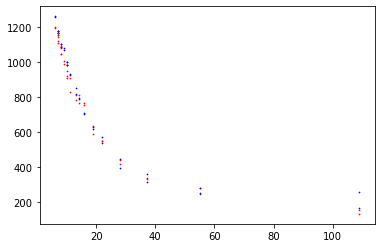

In [8]:
path = './examples/HumanCyc_2016.npy'
thresh = np.arange(10, 200, 10)#np.repeat(50,100)
C = 0
KL_modified = True
random_labels = False
unweighted = True

repeats = 2
thresh_out = []
out1 = []
out2 = []
for i in range(repeats):
    np.random.seed(i)
    results = process_map(partial(get_scores,path,C,KL_modified,False,unweighted,i), thresh)
    out1.append(results)
    
    thresh2 = np.ceil(np.array([np.mean(np.unique(x[0], return_counts = True)[1]) for x in results]))
    thresh_out.append(thresh2)
    plt.scatter(thresh2, [x[1] for x in results], c='red', s = .5)
    
    results = process_map(partial(get_scores,path,C,KL_modified,True,unweighted,i), thresh2)
    out2.append(results)
    plt.scatter(thresh2, [x[1] for x in results], c='blue', s = .5)

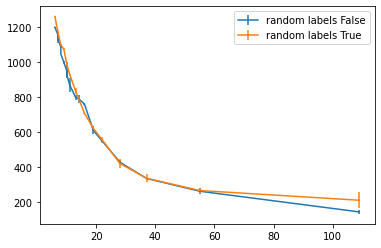

In [10]:
losses1 = np.empty(shape = (repeats,len(thresh)))
for i in range(repeats):
    losses1[i] = [x[1] for x in out1[i]]
    
losses2 = np.empty(shape = (repeats,len(thresh)))
for i in range(repeats):
    losses2[i] = [x[1] for x in out2[i]]
    
plt.errorbar(thresh_out[0], np.mean(losses1, axis = 0), yerr=np.std(losses1, axis = 0), label='random labels False')
plt.errorbar(thresh_out[0], np.mean(losses2, axis = 0), yerr=np.std(losses2, axis = 0), label='random labels True')
plt.legend(loc='upper right')


In [295]:
loss1 = np.stack([x[2][1] for x in out1])
lab1 = np.stack([x[2][0] for x in out1])

loss2 = np.stack([x[2][1] for x in out2])
lab2 = np.stack([x[2][0] for x in out2])

In [15]:
path = './examples/HumanCyc_2016.npy'
repeats = 1000

thresh = np.repeat(50,repeats)
seed = np.arange(repeats)
C = 0
KL_modified = True
random_labels = True
unweighted = True

results = process_map(partial(get_scores,path,C,KL_modified,False,unweighted), seed, thresh)


  0%|          | 0/1000 [00:00<?, ?it/s]

3it [00:05,  1.82s/it, tot_impr=1303, last_impr=0, loss=550]   
3it [00:05,  1.93s/it, tot_impr=1353, last_impr=0, loss=502] 
4it [00:05,  1.50s/it, tot_impr=1366, last_impr=0, loss=504]]
3it [00:05,  1.80s/it, tot_impr=1266, last_impr=0, loss=604] 
4it [00:05,  1.47s/it, tot_impr=1357, last_impr=0, loss=500] 
4it [00:06,  1.51s/it, tot_impr=1292, last_impr=0, loss=562]
3it [00:05,  1.86s/it, tot_impr=1348, last_impr=0, loss=519] 
4it [00:05,  1.49s/it, tot_impr=1307, last_impr=0, loss=549]
4it [00:05,  1.49s/it, tot_impr=1344, last_impr=0, loss=531]
4it [00:06,  1.54s/it, tot_impr=1326, last_impr=0, loss=534] 
4it [00:06,  1.55s/it, tot_impr=1351, last_impr=0, loss=504]
3it [00:05,  2.00s/it, tot_impr=1323, last_impr=0, loss=523] 
4it [00:06,  1.58s/it, tot_impr=1314, last_impr=0, loss=542] 
3it [00:06,  2.04s/it, tot_impr=1345, last_impr=0, loss=515] 
3it [00:06,  2.00s/it, tot_impr=1323, last_impr=0, loss=546] 
4it [00:06,  1.59s/it, tot_impr=1310, last_impr=0, loss=548]
4it [00:06,

In [28]:
loss = [x[1] for x in results]
labels = np.vstack([x[0] for x in results])

In [81]:
np.argmin(loss-np.min(loss))

761

In [97]:
out = []
curr = labels[np.argsort(loss)[0]]
for i in range(len(curr)):
    out.append(curr==curr[i])
dist = np.vstack(out)

In [98]:
output = []
for z in range(len(loss)):
    out = []
    curr = labels[np.argsort(loss)[z]]
    for i in range(len(curr)):
        out.append(curr==curr[i])
    dist2 = np.vstack(out)
    
    output.append(scipy.stats.spearmanr(dist.ravel(), dist2.ravel())[0])

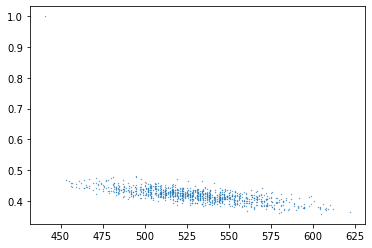

In [111]:
plt.scatter(np.array(loss)[np.argsort(loss)], output, s = 0.1)

In [108]:
# how does this method compare to other clustering methods

441

In [165]:
from sklearn.cluster import SpectralClustering
import numpy as np
X = get_full_matrix_from_bipartite(matrix)
clustering = SpectralClustering(n_clusters=50,
        assign_labels='discretize',
        random_state=1,affinity='precomputed_nearest_neighbors').fit(X)
labs = clustering.labels_

In [166]:
evaluate_cut(matrix, labs, 0)

1536

In [158]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=50, random_state=0).fit(X)
labs = kmeans.labels_

#kmeans.predict(X)

#kmeans.cluster_centers_

In [159]:
evaluate_cut(matrix, labs, 0)

1526

In [162]:
# how well connected are the clusters we identify using KL?
# how does it compare to results with the Leiden algorithm?, which is supposed to guarantee for better connectededness - how do they measure that?

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       dtype=int32),
 array([509,   6,  44,   5,  25,  32,  24,  27,   7,   1,  21,   8,   7,
         27,  22,  13,   3,  38,  24,  19,   8,   4,  16,   4,   2,   6,
          1,  11,   4,   3,   2,   9,   1,   9,  11,   1,   1,  20,  12,
         40,   1,  10,   2,   7,   6,  14,   2,   2,   1,  14]))

# below is scrap

In [94]:
import scipy
scipy.stats.spearmanr(dist.ravel(), dist2.ravel())

SpearmanrResult(correlation=0.3654673364019369, pvalue=0.0)

In [35]:
fill = np.zeros_like(matrix)

In [40]:
labels[0]

array([ 8, 29, 14, ...,  7, 43, 30])

In [33]:
curr = labels[0]
for i in len(curr):
    x,y = fill.shape
    if i<x:
        fill[i] 

array([ 8, 29, 14, ...,  7, 43, 30])

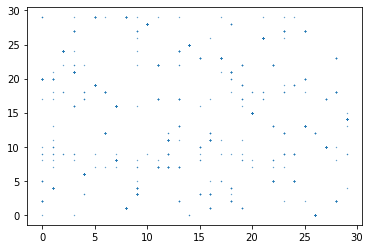

In [296]:
plt.scatter(lab1[np.argmin(loss1)], lab2[np.argmin(loss2)], s = 0.1)

In [310]:
x = lab1[np.argmin(loss1)]
y = lab2[np.argmin(loss2)]
y_former = y.copy()

In [311]:
run_KL(y, matrix, 0, True)

1it [00:00,  1.70it/s, tot_impr=0, last_impr=0, loss=284]


In [308]:
y

array([ 1, 13, 13, ..., 19, 12, 12])

In [298]:
counter1 = []
counter2 = []
for i in range(10000):
    index = np.random.choice(range(len(x)), 2)
    
    if (x[index[0]]-x[index[1]])==0:
        counter1.append((y[index[0]]-y[index[1]])==0)
    else:
        counter2.append((y[index[0]]-y[index[1]])==0)

In [299]:
np.sum(counter1)/len(counter1)

0.5046728971962616

In [300]:
np.sum(counter2)/len(counter2)

0.016943899163136687

In [206]:
counter

19

In [176]:
np.random.choice(np.where(test[0]==8), 1)

ValueError: a must be 1-dimensional

In [169]:
np.where(test[1]==8)

(array([   0,   16,   17,  113,  114,  115,  141,  155,  156,  172,  179,
         180,  181,  287,  289,  290,  291,  292,  293,  294,  295,  296,
         324,  331,  332,  333,  334,  335,  336,  337,  338,  339,  340,
         341,  342,  343,  344,  345,  346,  347,  348,  358,  361,  362,
         376,  449,  450,  451,  452,  453,  454,  455,  456,  457,  458,
         459,  574,  575,  576,  577,  621,  622,  623,  632,  633,  634,
         635,  641,  644,  749,  773,  775,  781,  801,  802,  803,  804,
         811,  812,  813,  814,  819,  820,  830,  831,  833,  846,  855,
         928, 1053, 1054, 1066, 1067, 1072, 1079, 1081, 1084, 1085]),)

In [168]:
test

array([[8, 5, 5, ..., 8, 8, 5],
       [8, 6, 6, ..., 7, 8, 8],
       [5, 5, 2, ..., 9, 3, 9],
       ...,
       [8, 4, 1, ..., 8, 1, 1],
       [8, 1, 1, ..., 7, 7, 7],
       [9, 5, 5, ..., 3, 3, 3]])

In [98]:
results = process_map(partial(get_scores,path,C,KL_modified,False,unweighted), thresh)

  0%|          | 0/19 [00:00<?, ?it/s]

3it [00:01,  1.99it/s, tot_impr=1101, last_impr=0, loss=782]  ]
3it [00:01,  1.93it/s, tot_impr=958, last_impr=0, loss=906] ]  
3it [00:01,  1.84it/s, tot_impr=975, last_impr=0, loss=908]  
4it [00:01,  2.08it/s, tot_impr=1242, last_impr=0, loss=631] 
4it [00:01,  2.01it/s, tot_impr=1317, last_impr=0, loss=548] 
4it [00:01,  2.03it/s, tot_impr=1063, last_impr=0, loss=812]
4it [00:02,  1.87it/s, tot_impr=1410, last_impr=0, loss=438] 
3it [00:02,  1.38it/s, tot_impr=747, last_impr=0, loss=1144] 
3it [00:02,  1.32it/s, tot_impr=695, last_impr=0, loss=1195] 
4it [00:02,  1.78it/s, tot_impr=908, last_impr=0, loss=980]
4it [00:02,  1.72it/s, tot_impr=870, last_impr=0, loss=1007]
3it [00:02,  1.24it/s, tot_impr=1527, last_impr=0, loss=278] 
4it [00:02,  1.65it/s, tot_impr=845, last_impr=0, loss=1044]
5it [00:02,  2.08it/s, tot_impr=1112, last_impr=0, loss=755]
4it [00:02,  1.59it/s, tot_impr=814, last_impr=0, loss=1077]
4it [00:02,  1.56it/s, tot_impr=1501, last_impr=0, loss=333]
4it [00:02, 

In [102]:
np.ceil([np.mean(np.unique(x[0], return_counts = True)[1]) for x in results])

array([109.,  55.,  37.,  28.,  22.,  19.,  16.,  14.,  13.,  11.,  10.,
        10.,   9.,   8.,   8.,   7.,   7.,   7.,   6.])

In [64]:
path = './examples/HumanCyc_2016.npy'
thresh = np.arange(10, 200, 10)#np.repeat(50,100)
C = 0
KL_modified = True
random_labels = False
unweighted = True

repeats = 10
out = []
for i in range(repeats):
    np.random.seed(i)
    results = process_map(partial(get_scores,path,C,KL_modified,random_labels,unweighted), thresh)
    out.append(results)
    #plt.plot(thresh, [x[1] for x in results])

  0%|          | 0/19 [00:00<?, ?it/s]

3it [00:01,  1.73it/s, tot_impr=1101, last_impr=0, loss=782]   
3it [00:01,  1.69it/s, tot_impr=958, last_impr=0, loss=906]  
4it [00:02,  1.87it/s, tot_impr=1242, last_impr=0, loss=631]59]
4it [00:02,  1.83it/s, tot_impr=1063, last_impr=0, loss=812] 
4it [00:02,  1.76it/s, tot_impr=1317, last_impr=0, loss=548] 
4it [00:02,  1.76it/s, tot_impr=1410, last_impr=0, loss=438]
3it [00:02,  1.26it/s, tot_impr=747, last_impr=0, loss=1144]  
3it [00:01,  1.75it/s, tot_impr=975, last_impr=0, loss=908] 
4it [00:02,  1.62it/s, tot_impr=908, last_impr=0, loss=980]
5it [00:02,  1.87it/s, tot_impr=1112, last_impr=0, loss=755]
4it [00:02,  1.51it/s, tot_impr=845, last_impr=0, loss=1044]
3it [00:02,  1.08it/s, tot_impr=1527, last_impr=0, loss=278] 
4it [00:02,  1.46it/s, tot_impr=814, last_impr=0, loss=1077]
4it [00:02,  1.70it/s, tot_impr=870, last_impr=0, loss=1007]
4it [00:02,  1.39it/s, tot_impr=1501, last_impr=0, loss=333]
4it [00:02,  1.41it/s, tot_impr=733, last_impr=0, loss=1155]
4it [00:02,  

  0%|          | 0/19 [00:00<?, ?it/s]

3it [00:02,  1.42it/s, tot_impr=1447, last_impr=0, loss=416] 5]
3it [00:02,  1.38it/s, tot_impr=966, last_impr=0, loss=921]    
4it [00:02,  1.58it/s, tot_impr=1310, last_impr=0, loss=548]] 
3it [00:02,  1.39it/s, tot_impr=1068, last_impr=0, loss=811] 
4it [00:02,  1.58it/s, tot_impr=1115, last_impr=0, loss=766]]  
4it [00:02,  1.52it/s, tot_impr=1054, last_impr=0, loss=830]
3it [00:02,  1.13it/s, tot_impr=737, last_impr=0, loss=1154] 
3it [00:02,  1.17it/s, tot_impr=777, last_impr=0, loss=1109] 
3it [00:02,  1.08it/s, tot_impr=721, last_impr=0, loss=1166] 
4it [00:02,  1.35it/s, tot_impr=1116, last_impr=0, loss=763]
4it [00:03,  1.33it/s, tot_impr=898, last_impr=0, loss=988]] 
4it [00:03,  1.29it/s, tot_impr=833, last_impr=0, loss=1047]
4it [00:03,  1.23it/s, tot_impr=795, last_impr=0, loss=1090]
4it [00:02,  1.36it/s, tot_impr=937, last_impr=0, loss=948]
4it [00:03,  1.04it/s, tot_impr=1281, last_impr=0, loss=586] 
4it [00:03,  1.05it/s, tot_impr=693, last_impr=0, loss=1199]]  
4it [

  0%|          | 0/19 [00:00<?, ?it/s]

3it [00:01,  1.93it/s, tot_impr=1128, last_impr=0, loss=749] 0]
3it [00:01,  1.76it/s, tot_impr=980, last_impr=0, loss=906] ]  
3it [00:01,  1.69it/s, tot_impr=874, last_impr=0, loss=1010]  
3it [00:01,  1.56it/s, tot_impr=845, last_impr=0, loss=1041] 
4it [00:01,  2.04it/s, tot_impr=1204, last_impr=0, loss=674]
4it [00:01,  2.01it/s, tot_impr=1357, last_impr=0, loss=500]
3it [00:02,  1.42it/s, tot_impr=758, last_impr=0, loss=1133] 
4it [00:02,  1.56it/s, tot_impr=824, last_impr=0, loss=1059] 
3it [00:02,  1.16it/s, tot_impr=715, last_impr=0, loss=1180] 
5it [00:02,  1.84it/s, tot_impr=1067, last_impr=0, loss=810]
4it [00:02,  1.47it/s, tot_impr=1450, last_impr=0, loss=364]
5it [00:02,  1.74it/s, tot_impr=1426, last_impr=0, loss=424]
4it [00:02,  1.42it/s, tot_impr=784, last_impr=0, loss=1107]
5it [00:02,  1.74it/s, tot_impr=1061, last_impr=0, loss=821]
5it [00:03,  1.65it/s, tot_impr=973, last_impr=0, loss=913]
6it [00:03,  1.90it/s, tot_impr=1219, last_impr=0, loss=645]
4it [00:03,  

  0%|          | 0/19 [00:00<?, ?it/s]

3it [00:02,  1.45it/s, tot_impr=1022, last_impr=0, loss=862] 4]
3it [00:02,  1.32it/s, tot_impr=866, last_impr=0, loss=1024]  
4it [00:02,  1.47it/s, tot_impr=1373, last_impr=0, loss=467]]  
4it [00:02,  1.65it/s, tot_impr=1120, last_impr=0, loss=764] 
4it [00:02,  1.40it/s, tot_impr=907, last_impr=0, loss=979]
3it [00:02,  1.05it/s, tot_impr=998, last_impr=0, loss=884] 
5it [00:03,  1.60it/s, tot_impr=1206, last_impr=0, loss=667] 
4it [00:03,  1.28it/s, tot_impr=1207, last_impr=0, loss=667]
5it [00:03,  1.54it/s, tot_impr=1312, last_impr=0, loss=548]
4it [00:03,  1.25it/s, tot_impr=841, last_impr=0, loss=1045]
4it [00:03,  1.19it/s, tot_impr=1496, last_impr=0, loss=347]
4it [00:03,  1.21it/s, tot_impr=937, last_impr=0, loss=953]
4it [00:03,  1.13it/s, tot_impr=741, last_impr=0, loss=1148]
4it [00:03,  1.16it/s, tot_impr=818, last_impr=0, loss=1070]
3it [00:03,  1.11s/it, tot_impr=1525, last_impr=0, loss=276] 
4it [00:03,  1.20it/s, tot_impr=787, last_impr=0, loss=1104]
4it [00:03,  1.

  0%|          | 0/19 [00:00<?, ?it/s]

3it [00:01,  2.02it/s, tot_impr=1266, last_impr=0, loss=604]   
3it [00:01,  1.97it/s, tot_impr=1028, last_impr=0, loss=850] 6]
3it [00:01,  2.00it/s, tot_impr=1105, last_impr=0, loss=778] 
4it [00:02,  1.96it/s, tot_impr=1272, last_impr=0, loss=602]   
4it [00:02,  1.94it/s, tot_impr=1192, last_impr=0, loss=686] 
3it [00:02,  1.41it/s, tot_impr=756, last_impr=0, loss=1133] 
3it [00:02,  1.32it/s, tot_impr=768, last_impr=0, loss=1120] 
4it [00:02,  1.66it/s, tot_impr=961, last_impr=0, loss=926]]
4it [00:02,  1.54it/s, tot_impr=832, last_impr=0, loss=1053] 
4it [00:02,  1.57it/s, tot_impr=887, last_impr=0, loss=1004]
3it [00:02,  1.13it/s, tot_impr=1531, last_impr=0, loss=274] 
4it [00:02,  1.45it/s, tot_impr=1501, last_impr=0, loss=330]
5it [00:02,  1.79it/s, tot_impr=1018, last_impr=0, loss=869]
4it [00:02,  1.46it/s, tot_impr=757, last_impr=0, loss=1134]
5it [00:02,  1.72it/s, tot_impr=1438, last_impr=0, loss=416]
5it [00:02,  1.73it/s, tot_impr=976, last_impr=0, loss=904]
4it [00:03

  0%|          | 0/19 [00:00<?, ?it/s]

3it [00:01,  1.63it/s, tot_impr=1314, last_impr=0, loss=556]  ]
3it [00:02,  1.49it/s, tot_impr=927, last_impr=0, loss=955]   ]
3it [00:02,  1.23it/s, tot_impr=1548, last_impr=0, loss=301]   
4it [00:02,  1.62it/s, tot_impr=1351, last_impr=0, loss=504] 
4it [00:02,  1.62it/s, tot_impr=1129, last_impr=0, loss=751]
3it [00:02,  1.15it/s, tot_impr=736, last_impr=0, loss=1151] 
4it [00:02,  1.48it/s, tot_impr=1463, last_impr=0, loss=389]
3it [00:02,  1.07it/s, tot_impr=693, last_impr=0, loss=1201] 
4it [00:02,  1.37it/s, tot_impr=828, last_impr=0, loss=1062] 
4it [00:03,  1.33it/s, tot_impr=924, last_impr=0, loss=963]] 
4it [00:03,  1.32it/s, tot_impr=861, last_impr=0, loss=1028]
5it [00:03,  1.59it/s, tot_impr=1017, last_impr=0, loss=868]
4it [00:03,  1.26it/s, tot_impr=803, last_impr=0, loss=1085]]  
5it [00:03,  1.56it/s, tot_impr=981, last_impr=0, loss=899]
4it [00:03,  1.16it/s, tot_impr=731, last_impr=0, loss=1156]
4it [00:03,  1.07it/s, tot_impr=714, last_impr=0, loss=1176]
5it [00:

  0%|          | 0/19 [00:00<?, ?it/s]

3it [00:01,  1.81it/s, tot_impr=1180, last_impr=0, loss=689] 3]
3it [00:01,  1.74it/s, tot_impr=1034, last_impr=0, loss=850]  
3it [00:01,  1.53it/s, tot_impr=871, last_impr=0, loss=1018]   
4it [00:02,  1.86it/s, tot_impr=1300, last_impr=0, loss=560] 
4it [00:02,  1.86it/s, tot_impr=1248, last_impr=0, loss=614]
4it [00:02,  1.83it/s, tot_impr=1124, last_impr=0, loss=759]
3it [00:02,  1.37it/s, tot_impr=763, last_impr=0, loss=1127] 
4it [00:02,  1.76it/s, tot_impr=1023, last_impr=0, loss=853]
4it [00:02,  1.70it/s, tot_impr=1459, last_impr=0, loss=386]
3it [00:02,  1.30it/s, tot_impr=764, last_impr=0, loss=1130] 
4it [00:02,  1.69it/s, tot_impr=961, last_impr=0, loss=917]
3it [00:02,  1.26it/s, tot_impr=704, last_impr=0, loss=1190] 
4it [00:02,  1.63it/s, tot_impr=909, last_impr=0, loss=978]
3it [00:02,  1.22it/s, tot_impr=658, last_impr=0, loss=1237] 
4it [00:02,  1.45it/s, tot_impr=833, last_impr=0, loss=1061] 
4it [00:02,  1.42it/s, tot_impr=1440, last_impr=0, loss=391]
4it [00:02, 

  0%|          | 0/19 [00:00<?, ?it/s]

3it [00:01,  1.55it/s, tot_impr=1323, last_impr=0, loss=546]   
3it [00:02,  1.41it/s, tot_impr=854, last_impr=0, loss=1030] 
3it [00:02,  1.24it/s, tot_impr=1519, last_impr=0, loss=308]   
4it [00:02,  1.50it/s, tot_impr=1456, last_impr=0, loss=398]]
4it [00:02,  1.43it/s, tot_impr=909, last_impr=0, loss=977]187]
4it [00:02,  1.58it/s, tot_impr=1066, last_impr=0, loss=820] 
3it [00:02,  1.00it/s, tot_impr=1085, last_impr=0, loss=792]  
5it [00:03,  1.66it/s, tot_impr=1163, last_impr=0, loss=710]
3it [00:03,  1.03s/it, tot_impr=861, last_impr=0, loss=1027]   
5it [00:03,  1.49it/s, tot_impr=937, last_impr=0, loss=950]] 
3it [00:03,  1.11s/it, tot_impr=793, last_impr=0, loss=1100] 
4it [00:03,  1.21it/s, tot_impr=1066, last_impr=0, loss=812] 
4it [00:03,  1.10it/s, tot_impr=710, last_impr=0, loss=1180]
5it [00:03,  1.27it/s, tot_impr=1266, last_impr=0, loss=603] 
4it [00:04,  1.05s/it, tot_impr=788, last_impr=0, loss=1104] 
4it [00:04,  1.08s/it, tot_impr=735, last_impr=0, loss=1151]
4i

  0%|          | 0/19 [00:00<?, ?it/s]

3it [00:02,  1.17it/s, tot_impr=896, last_impr=0, loss=994]    
3it [00:02,  1.35it/s, tot_impr=1353, last_impr=0, loss=502] 
4it [00:02,  1.56it/s, tot_impr=1231, last_impr=0, loss=642]
3it [00:02,  1.26it/s, tot_impr=805, last_impr=0, loss=1086] 
4it [00:02,  1.41it/s, tot_impr=1444, last_impr=0, loss=412]  
4it [00:02,  1.37it/s, tot_impr=1142, last_impr=0, loss=724] 
3it [00:02,  1.02it/s, tot_impr=1003, last_impr=0, loss=882] 
3it [00:02,  1.05it/s, tot_impr=1065, last_impr=0, loss=820]   
3it [00:02,  1.05it/s, tot_impr=698, last_impr=0, loss=1196] 
4it [00:03,  1.30it/s, tot_impr=969, last_impr=0, loss=916]
4it [00:03,  1.32it/s, tot_impr=857, last_impr=0, loss=1031]
4it [00:03,  1.21it/s, tot_impr=760, last_impr=0, loss=1131]
4it [00:03,  1.08it/s, tot_impr=1075, last_impr=0, loss=805]]  
4it [00:03,  1.16it/s, tot_impr=756, last_impr=0, loss=1135]
5it [00:03,  1.26it/s, tot_impr=1456, last_impr=0, loss=375]
4it [00:04,  1.09s/it, tot_impr=949, last_impr=0, loss=934]] 
4it [00:

  0%|          | 0/19 [00:00<?, ?it/s]

3it [00:02,  1.41it/s, tot_impr=890, last_impr=0, loss=995]    
3it [00:02,  1.31it/s, tot_impr=826, last_impr=0, loss=1055] 
4it [00:02,  1.61it/s, tot_impr=1245, last_impr=0, loss=627]] 
4it [00:02,  1.59it/s, tot_impr=1132, last_impr=0, loss=742] 
4it [00:02,  1.59it/s, tot_impr=1078, last_impr=0, loss=794]
4it [00:02,  1.49it/s, tot_impr=1443, last_impr=0, loss=413] 
3it [00:02,  1.14it/s, tot_impr=812, last_impr=0, loss=1074] 
4it [00:02,  1.37it/s, tot_impr=900, last_impr=0, loss=981]]]  
5it [00:03,  1.56it/s, tot_impr=1019, last_impr=0, loss=852] 
5it [00:03,  1.53it/s, tot_impr=1300, last_impr=0, loss=566]] 
4it [00:03,  1.23it/s, tot_impr=771, last_impr=0, loss=1117]
5it [00:03,  1.54it/s, tot_impr=1012, last_impr=0, loss=871]
5it [00:02,  1.68it/s, tot_impr=1150, last_impr=0, loss=723]
4it [00:03,  1.19it/s, tot_impr=718, last_impr=0, loss=1170]
3it [00:03,  1.08s/it, tot_impr=1494, last_impr=0, loss=347] 
4it [00:03,  1.01it/s, tot_impr=1544, last_impr=0, loss=253]]  
3it [

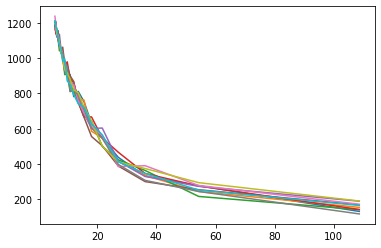

In [88]:
means = []
for i in range(len(out)):
    res = out[i]
    mean = [np.mean(np.unique(x[0], return_counts = True)[1]) for x in res]
    means.append(mean)
    plt.plot(mean, [x[1] for x in res])

In [92]:
path = './examples/HumanCyc_2016.npy'
thresh = np.unique(np.round(means[0]))
C = 0
KL_modified = True
random_labels = True
unweighted = True

repeats = 10
out = []
for i in range(repeats):
    np.random.seed(i)
    results = process_map(partial(get_scores,path,C,KL_modified,random_labels,unweighted), thresh)
    out.append(results)
    #plt.plot(thresh, [x[1] for x in results])

  0%|          | 0/15 [00:00<?, ?it/s]

3it [00:01,  1.98it/s, tot_impr=1230, last_impr=0, loss=639] 1]
3it [00:01,  1.93it/s, tot_impr=1081, last_impr=0, loss=796] 
3it [00:01,  1.77it/s, tot_impr=884, last_impr=0, loss=997] ]  
3it [00:01,  1.68it/s, tot_impr=818, last_impr=0, loss=1066] 
4it [00:02,  1.95it/s, tot_impr=1171, last_impr=0, loss=705] 
4it [00:02,  1.86it/s, tot_impr=986, last_impr=0, loss=894]] 
4it [00:02,  1.77it/s, tot_impr=949, last_impr=0, loss=933]
3it [00:02,  1.25it/s, tot_impr=629, last_impr=0, loss=1260] 
4it [00:02,  1.62it/s, tot_impr=1545, last_impr=0, loss=295] 
5it [00:02,  1.96it/s, tot_impr=1332, last_impr=0, loss=538]
4it [00:02,  1.56it/s, tot_impr=801, last_impr=0, loss=1086]
5it [00:02,  1.90it/s, tot_impr=1408, last_impr=0, loss=447]
4it [00:02,  1.42it/s, tot_impr=726, last_impr=0, loss=1164]
4it [00:03,  1.28it/s, tot_impr=1553, last_impr=0, loss=264]]  
4it [00:05,  1.37s/it, tot_impr=1468, last_impr=0, loss=255] 


  0%|          | 0/15 [00:00<?, ?it/s]

3it [00:01,  1.89it/s, tot_impr=1404, last_impr=0, loss=451]  ]
3it [00:01,  1.92it/s, tot_impr=1163, last_impr=0, loss=709]   
3it [00:01,  1.83it/s, tot_impr=1091, last_impr=0, loss=785] 
3it [00:01,  1.74it/s, tot_impr=903, last_impr=0, loss=979]   
3it [00:01,  1.56it/s, tot_impr=780, last_impr=0, loss=1104] 
4it [00:02,  1.93it/s, tot_impr=1298, last_impr=0, loss=572]
4it [00:02,  1.80it/s, tot_impr=955, last_impr=0, loss=925]] 
4it [00:02,  1.74it/s, tot_impr=978, last_impr=0, loss=906]
4it [00:02,  1.69it/s, tot_impr=802, last_impr=0, loss=1080]
3it [00:02,  1.24it/s, tot_impr=632, last_impr=0, loss=1257] 
5it [00:02,  1.98it/s, tot_impr=1230, last_impr=0, loss=646]
4it [00:02,  1.57it/s, tot_impr=1532, last_impr=0, loss=307] 
4it [00:02,  1.42it/s, tot_impr=713, last_impr=0, loss=1177]
4it [00:03,  1.28it/s, tot_impr=1568, last_impr=0, loss=257]]  
3it [00:04,  1.39s/it, tot_impr=1551, last_impr=0, loss=165] 


  0%|          | 0/15 [00:00<?, ?it/s]

3it [00:01,  1.93it/s, tot_impr=1078, last_impr=0, loss=798] 7]
3it [00:01,  1.84it/s, tot_impr=956, last_impr=0, loss=924]    
3it [00:01,  1.80it/s, tot_impr=932, last_impr=0, loss=950] 
3it [00:01,  1.78it/s, tot_impr=916, last_impr=0, loss=966] 
3it [00:01,  1.56it/s, tot_impr=783, last_impr=0, loss=1105]  
4it [00:02,  1.99it/s, tot_impr=1234, last_impr=0, loss=644]
4it [00:02,  1.97it/s, tot_impr=1323, last_impr=0, loss=541]
4it [00:02,  1.95it/s, tot_impr=1161, last_impr=0, loss=715] 
4it [00:02,  1.93it/s, tot_impr=1352, last_impr=0, loss=501]
3it [00:02,  1.42it/s, tot_impr=712, last_impr=0, loss=1178] 
4it [00:02,  1.69it/s, tot_impr=840, last_impr=0, loss=1044] 
3it [00:02,  1.25it/s, tot_impr=632, last_impr=0, loss=1256]
4it [00:02,  1.61it/s, tot_impr=1546, last_impr=0, loss=297] 
4it [00:03,  1.29it/s, tot_impr=1518, last_impr=0, loss=291]]  
3it [00:04,  1.38s/it, tot_impr=1506, last_impr=0, loss=199] 


  0%|          | 0/15 [00:00<?, ?it/s]

3it [00:01,  1.98it/s, tot_impr=1355, last_impr=0, loss=508] 0]
3it [00:01,  1.88it/s, tot_impr=1133, last_impr=0, loss=736] 
3it [00:01,  1.84it/s, tot_impr=986, last_impr=0, loss=894] ]  
3it [00:01,  1.78it/s, tot_impr=941, last_impr=0, loss=939] 
3it [00:01,  1.73it/s, tot_impr=906, last_impr=0, loss=974]] 
4it [00:02,  1.90it/s, tot_impr=1406, last_impr=0, loss=444] 
4it [00:02,  1.93it/s, tot_impr=1095, last_impr=0, loss=776]
4it [00:02,  1.69it/s, tot_impr=833, last_impr=0, loss=1054] 
5it [00:02,  1.98it/s, tot_impr=1208, last_impr=0, loss=662] 
4it [00:02,  1.53it/s, tot_impr=1465, last_impr=0, loss=369]
4it [00:02,  1.56it/s, tot_impr=772, last_impr=0, loss=1113]
4it [00:02,  1.42it/s, tot_impr=713, last_impr=0, loss=1177]
4it [00:03,  1.28it/s, tot_impr=1519, last_impr=0, loss=275]2] 
4it [00:03,  1.25it/s, tot_impr=627, last_impr=0, loss=1264]
4it [00:05,  1.37s/it, tot_impr=1535, last_impr=0, loss=146]  


  0%|          | 0/15 [00:00<?, ?it/s]

3it [00:01,  1.76it/s, tot_impr=894, last_impr=0, loss=986]    
3it [00:01,  1.68it/s, tot_impr=844, last_impr=0, loss=1041] 
4it [00:02,  2.00it/s, tot_impr=1224, last_impr=0, loss=648] 
4it [00:02,  1.97it/s, tot_impr=1301, last_impr=0, loss=561]
4it [00:02,  1.93it/s, tot_impr=1079, last_impr=0, loss=802]
4it [00:02,  1.93it/s, tot_impr=1117, last_impr=0, loss=758]
4it [00:02,  1.85it/s, tot_impr=991, last_impr=0, loss=886]] 
4it [00:02,  1.78it/s, tot_impr=952, last_impr=0, loss=928]
3it [00:02,  1.25it/s, tot_impr=1502, last_impr=0, loss=304] 
3it [00:02,  1.25it/s, tot_impr=623, last_impr=0, loss=1268]
4it [00:02,  1.58it/s, tot_impr=1415, last_impr=0, loss=424]
4it [00:02,  1.54it/s, tot_impr=796, last_impr=0, loss=1093]
5it [00:02,  1.93it/s, tot_impr=1407, last_impr=0, loss=445]
4it [00:02,  1.41it/s, tot_impr=712, last_impr=0, loss=1179]
5it [00:06,  1.40s/it, tot_impr=1526, last_impr=0, loss=185]   


  0%|          | 0/15 [00:00<?, ?it/s]

3it [00:01,  1.96it/s, tot_impr=1178, last_impr=0, loss=698] 5]
3it [00:01,  1.68it/s, tot_impr=846, last_impr=0, loss=1042]   
4it [00:02,  1.97it/s, tot_impr=1319, last_impr=0, loss=552] 
4it [00:02,  1.92it/s, tot_impr=1387, last_impr=0, loss=470]
4it [00:02,  1.92it/s, tot_impr=1091, last_impr=0, loss=792]
3it [00:02,  1.40it/s, tot_impr=714, last_impr=0, loss=1180]
4it [00:02,  1.85it/s, tot_impr=1012, last_impr=0, loss=875]
4it [00:02,  1.79it/s, tot_impr=975, last_impr=0, loss=913]
4it [00:02,  1.76it/s, tot_impr=907, last_impr=0, loss=979]
3it [00:02,  1.29it/s, tot_impr=1529, last_impr=0, loss=287] 
3it [00:02,  1.24it/s, tot_impr=633, last_impr=0, loss=1264]
5it [00:02,  2.01it/s, tot_impr=1247, last_impr=0, loss=627]
4it [00:02,  1.56it/s, tot_impr=768, last_impr=0, loss=1124]
4it [00:02,  1.57it/s, tot_impr=1485, last_impr=0, loss=361]
4it [00:05,  1.37s/it, tot_impr=1541, last_impr=0, loss=182]   


  0%|          | 0/15 [00:00<?, ?it/s]

3it [00:01,  1.93it/s, tot_impr=1070, last_impr=0, loss=812] 9]
3it [00:01,  1.90it/s, tot_impr=1400, last_impr=0, loss=464] 
3it [00:01,  1.79it/s, tot_impr=953, last_impr=0, loss=933]    
3it [00:01,  1.68it/s, tot_impr=832, last_impr=0, loss=1057] 
3it [00:01,  1.55it/s, tot_impr=782, last_impr=0, loss=1111] 
4it [00:02,  1.96it/s, tot_impr=1177, last_impr=0, loss=701]
4it [00:02,  1.97it/s, tot_impr=1344, last_impr=0, loss=523]
3it [00:02,  1.40it/s, tot_impr=719, last_impr=0, loss=1176] 
4it [00:02,  1.86it/s, tot_impr=1008, last_impr=0, loss=870]
4it [00:02,  1.77it/s, tot_impr=918, last_impr=0, loss=972]
3it [00:02,  1.25it/s, tot_impr=632, last_impr=0, loss=1263] 
4it [00:02,  1.60it/s, tot_impr=1481, last_impr=0, loss=365]
5it [00:02,  2.00it/s, tot_impr=1241, last_impr=0, loss=635]
4it [00:03,  1.30it/s, tot_impr=1520, last_impr=0, loss=296]]  
3it [00:04,  1.38s/it, tot_impr=1550, last_impr=0, loss=163] 


  0%|          | 0/15 [00:00<?, ?it/s]

3it [00:01,  1.92it/s, tot_impr=1081, last_impr=0, loss=796] 3]
3it [00:01,  1.86it/s, tot_impr=984, last_impr=0, loss=892] ]  
3it [00:01,  1.79it/s, tot_impr=939, last_impr=0, loss=948] 
3it [00:01,  1.53it/s, tot_impr=1445, last_impr=0, loss=389] 
4it [00:02,  1.98it/s, tot_impr=1232, last_impr=0, loss=643]
4it [00:02,  1.98it/s, tot_impr=1288, last_impr=0, loss=568] 
4it [00:02,  1.96it/s, tot_impr=1156, last_impr=0, loss=712]
4it [00:02,  1.91it/s, tot_impr=1417, last_impr=0, loss=440]
3it [00:02,  1.41it/s, tot_impr=699, last_impr=0, loss=1196] 
4it [00:02,  1.77it/s, tot_impr=900, last_impr=0, loss=985]
4it [00:02,  1.68it/s, tot_impr=844, last_impr=0, loss=1043]
3it [00:02,  1.24it/s, tot_impr=630, last_impr=0, loss=1263] 
4it [00:02,  1.58it/s, tot_impr=798, last_impr=0, loss=1090]
4it [00:03,  1.29it/s, tot_impr=1513, last_impr=0, loss=298]]  
4it [00:05,  1.39s/it, tot_impr=1569, last_impr=0, loss=153] 


  0%|          | 0/15 [00:00<?, ?it/s]

3it [00:01,  1.88it/s, tot_impr=1167, last_impr=0, loss=696]  ]
3it [00:01,  1.70it/s, tot_impr=888, last_impr=0, loss=996] ]  
3it [00:01,  1.55it/s, tot_impr=823, last_impr=0, loss=1061] 
4it [00:02,  1.93it/s, tot_impr=1131, last_impr=0, loss=741] 
4it [00:02,  1.98it/s, tot_impr=1323, last_impr=0, loss=536]
3it [00:02,  1.41it/s, tot_impr=706, last_impr=0, loss=1181]
4it [00:02,  1.91it/s, tot_impr=1085, last_impr=0, loss=788]
4it [00:02,  1.84it/s, tot_impr=1417, last_impr=0, loss=439]
4it [00:02,  1.73it/s, tot_impr=939, last_impr=0, loss=942]
3it [00:02,  1.24it/s, tot_impr=612, last_impr=0, loss=1282]
4it [00:02,  1.55it/s, tot_impr=1493, last_impr=0, loss=343] 
5it [00:02,  1.86it/s, tot_impr=992, last_impr=0, loss=884]]
4it [00:03,  1.23it/s, tot_impr=1572, last_impr=0, loss=241]]  
5it [00:03,  1.56it/s, tot_impr=792, last_impr=0, loss=1095]
4it [00:05,  1.39s/it, tot_impr=1534, last_impr=0, loss=166] 


  0%|          | 0/15 [00:00<?, ?it/s]

3it [00:01,  1.94it/s, tot_impr=1085, last_impr=0, loss=783] 5]
3it [00:01,  1.57it/s, tot_impr=1521, last_impr=0, loss=311]   
4it [00:01,  2.00it/s, tot_impr=1222, last_impr=0, loss=642] 
4it [00:02,  1.97it/s, tot_impr=1312, last_impr=0, loss=549]
4it [00:02,  1.95it/s, tot_impr=1169, last_impr=0, loss=701]
4it [00:02,  1.92it/s, tot_impr=1386, last_impr=0, loss=460]
3it [00:02,  1.42it/s, tot_impr=722, last_impr=0, loss=1166] 
4it [00:02,  1.85it/s, tot_impr=980, last_impr=0, loss=895]
4it [00:02,  1.80it/s, tot_impr=938, last_impr=0, loss=943]
4it [00:02,  1.79it/s, tot_impr=905, last_impr=0, loss=977]
4it [00:02,  1.69it/s, tot_impr=849, last_impr=0, loss=1033]
3it [00:02,  1.23it/s, tot_impr=629, last_impr=0, loss=1260] 
4it [00:02,  1.57it/s, tot_impr=781, last_impr=0, loss=1107]
4it [00:03,  1.28it/s, tot_impr=1543, last_impr=0, loss=258]]  
4it [00:05,  1.37s/it, tot_impr=1564, last_impr=0, loss=137] 


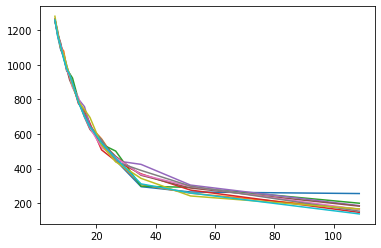

In [93]:
means = []
for i in range(len(out)):
    res = out[i]
    mean = [np.mean(np.unique(x[0], return_counts = True)[1]) for x in res]
    means.append(mean)
    plt.plot(mean, [x[1] for x in res])

In [79]:
res

(array([3, 0, 5, ..., 7, 6, 8]), 166)

108.6

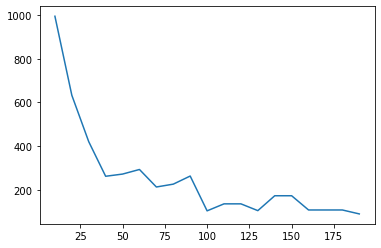

In [47]:
import matplotlib.pyplot as plt
plt.plot(thresh, [x[1] for x in results])

In [40]:
results

[(array([15, 21,  4, ...,  6,  7, 12]), 273),
 (array([15, 21,  4, ...,  6,  7, 12]), 273),
 (array([15, 21,  4, ...,  6,  7, 12]), 273),
 (array([15, 21,  4, ...,  6,  7, 12]), 273),
 (array([15, 21,  4, ...,  6,  7, 12]), 273),
 (array([15, 21,  4, ...,  6,  7, 12]), 273),
 (array([15, 21,  4, ...,  6,  7, 12]), 273),
 (array([15, 21,  4, ...,  6,  7, 12]), 273),
 (array([15, 21,  4, ...,  6,  7, 12]), 273),
 (array([15, 21,  4, ...,  6,  7, 12]), 273),
 (array([15, 21,  4, ...,  6,  7, 12]), 273),
 (array([15, 21,  4, ...,  6,  7, 12]), 273),
 (array([15, 21,  4, ...,  6,  7, 12]), 273),
 (array([15, 21,  4, ...,  6,  7, 12]), 273),
 (array([15, 21,  4, ...,  6,  7, 12]), 273),
 (array([15, 21,  4, ...,  6,  7, 12]), 273),
 (array([15, 21,  4, ...,  6,  7, 12]), 273),
 (array([15, 21,  4, ...,  6,  7, 12]), 273),
 (array([15, 21,  4, ...,  6,  7, 12]), 273),
 (array([15, 21,  4, ...,  6,  7, 12]), 273),
 (array([15, 21,  4, ...,  6,  7, 12]), 273),
 (array([15, 21,  4, ...,  6,  7, 

In [ ]:
process_map(partial(get_scores,path,C=0,KL_modified=True,random_labels=True,unweighted=True),(np.array([2,3])))

  0%|          | 0/2 [00:00<?, ?it/s]

In [37]:

partial(get_scores,path,C,KL_modified,random_labels,unweighted)(2)

2it [00:05,  2.65s/it, tot_impr=151, last_impr=0, loss=1748]  


(array([483, 274,   3, ..., 315, 105,  84]), 1748)

In [3]:
thresholds = np.array([25, 50, 100, 200, 500, 1000])
results = process_map(partial(score_for_thres, matrix), thresholds)

265

In [89]:
# how consistent across repeats?
N = 50
c = 0
out = np.empty(shape = (N, 1086), dtype = int)
loss = np.empty(shape = (N,1))
for i in range(N):
    out[i] = np.array(get_kernighan_lin_clusters('./examples/HumanCyc_2016.npy', 50, c, KL_modified=True, random_labels=True, unweighted=True)[0])
    loss[i] = evaluate_cut(matrix, out[i], c)

4it [00:03,  1.23it/s, tot_impr=1508, last_impr=0, loss=310]   
4it [00:03,  1.06it/s, tot_impr=1547, last_impr=0, loss=273]   
3it [00:02,  1.33it/s, tot_impr=1533, last_impr=0, loss=287]   
1it [00:01,  1.01s/it, tot_impr=1469, last_impr=1469, loss=342]


KeyboardInterrupt: 

In [88]:
thresholds = np.array([25, 50, 100, 200, 500, 1000])
results = process_map(partial(score_for_thres, matrix), thresholds)

array([[252.],
       [306.]])

In [69]:
frame = get_kernighan_lin_clusters('./examples/HumanCyc_2016.npy', 22, 0, KL_modified=True, random_labels=True, unweighted=True)

4it [00:01,  2.13it/s, tot_impr=1334, last_impr=0, loss=532]   


In [77]:
loss = np.empty(shape = (2,1))
loss

array([[4.63778443e-310],
       [6.92377362e-310]])

array([[140138750153824, 140138750153824,  93869922358736, ...,
         93869801519360,  93869801519360,  93869801519360],
       [ 93869801519360,  93869801519360,               0, ...,
         93869801519360,  93869801519360,  93869801519360],
       [ 93869801519360,  93869801519360,  93869801519360, ...,
         93869801519360,  93869801519360,  93869801519360],
       ...,
       [140132142724464, 140132142724656, 140132142724848, ...,
        140132104221248, 140132104221376, 140132104221504],
       [140132104221632, 140132104221760, 140132104221888, ...,
        140132104269120, 140132104269248, 140132104269376],
       [140132104269504, 140132104269632, 140132104269760, ...,
        140132142577776, 140132142577968, 140132142578160]])

30

In [31]:
# evaluate cut independently
mat = get_gene_pathway_matrix('./examples/HumanCyc_2016.npy')

In [28]:
matrix.shape

(934, 152)

In [25]:
matrix.shape

(7173, 622)

19144

In [15]:
ar = np.array([[1,0,0],[0,1,0]])
labels = np.array([1,1,1,0,0])
evaluate_cut(ar, labels, 0)

1